In [1]:
import pandas as pd
from darts import TimeSeries
import numpy as np
import glob
import matplotlib.pyplot as plt

# training data years 2016-2019
train_prices_path = glob.glob("./prices_201*.csv")
train_rain_path = glob.glob("./rain_201*.csv")

# read in data
prices_train = pd.DataFrame()
rain_train = pd.DataFrame()

for f in train_prices_path:
    csv = pd.read_csv(f)
    prices_train = pd.concat([prices_train, csv])
for f in train_rain_path:
    csv = pd.read_csv(f)
    rain_train = pd.concat([rain_train, csv])

# precipitation for the month that each day is in
precip = []
# day since begging of training data
dayOfYear = range(prices_train.shape[0])

for p in rain_train.iloc[:,1]:
    for i in range(21): # 21 trading days per month
        precip.append(p)

X_train = np.column_stack((dayOfYear, precip)).astype(float)
Y_train = np.array(prices_train.iloc[:,1]).astype(float)

prices_20 = pd.read_csv('./prices_2020.csv')
rain_20 = pd.read_csv('./rain_2020.csv')

testDayOfYear = range(dayOfYear[len(dayOfYear)-1], dayOfYear[len(dayOfYear)-1] + prices_20.shape[0])
test_precip = []

for p in rain_20.iloc[:,1]:
    for i in range(21):
        test_precip.append(p)

#X_test = np.column_stack((testDayOfYear, test_precip)).astype(float)
#Y_test = np.array(prices_20.iloc[:,1]).astype(float)

print(rain_train.head())
print(prices_train.head())


   Unnamed: 0  Historical Monthly Rain
0           0                    11.81
1           1                    14.51
2           2                    29.16
3           3                    24.81
4           4                    15.42
   Unnamed: 0  Daily Price
0           0       226.44
1           1       229.29
2           2       226.62
3           3       239.00
4           4       247.54


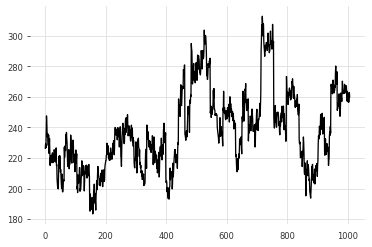

In [2]:
#plt.plot(rain_train.iloc[:,1])
plt.plot(Y_train)
#prices_train


(252, 3)

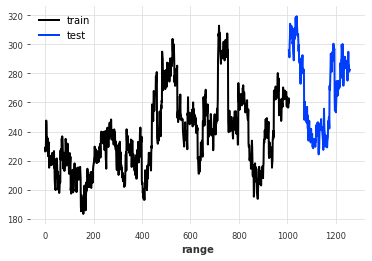

In [3]:

prices_train['range'] = dayOfYear
prices_20['range'] = testDayOfYear

train_series = TimeSeries.from_dataframe(prices_train, time_col='range', value_cols='Daily Price').astype(np.float32)
test_series = TimeSeries.from_dataframe(prices_20, time_col='range', value_cols='Daily Price').astype(np.float32)

train_series.plot(label='train')
test_series.plot(label='test')

prices_20.shape

(252, 2)

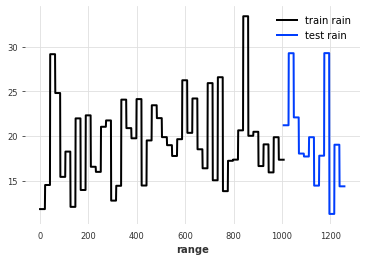

In [4]:
# making the future covariates series (weather data)
rain_train = pd.DataFrame()
rain_test = pd.DataFrame()

rain_train['rain'] = precip
rain_train['range'] = dayOfYear

rain_test['rain'] = test_precip
rain_test['range'] = testDayOfYear


train_covariates = TimeSeries.from_dataframe(rain_train, time_col='range', value_cols='rain').astype(np.float32)
test_covariates = TimeSeries.from_dataframe(rain_test, time_col='range', value_cols='rain').astype(np.float32)

train_covariates.plot(label='train rain')
test_covariates.plot(label='test rain')

rain_test.shape

In [5]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train_series)
prediction = model.predict(prices_20.shape[0], num_samples=1000)

Importing plotly failed. Interactive plots will not work.


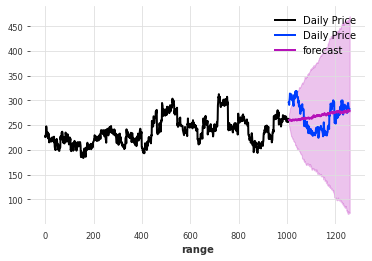

In [6]:
import matplotlib.pyplot as plt

train_series.plot()
test_series.plot()

prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

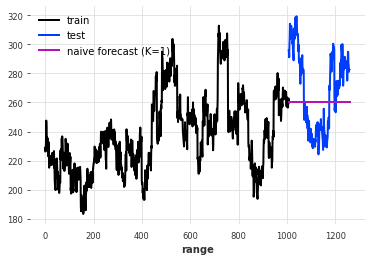

In [54]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train_series)
naive_forecast = naive_model.predict(prices_20.shape[0])

train_series.plot(label="train")
test_series.plot(label="test")

naive_forecast.plot(label="naive forecast (K=1)")

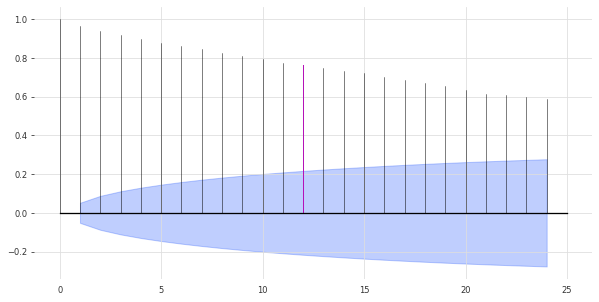

In [57]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train_series, m=12, alpha=0.1)

# model show no very little seasonality so we will change methods

In [59]:
from darts.models import ExponentialSmoothing, AutoARIMA, Theta
from darts.metrics import mape


def eval_model(model):
    model.fit(train_series)
    forecast = model.predict(prices_20.shape[0])
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(test_series, forecast)))


eval_model(ExponentialSmoothing())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains MAPE: 9.17%
model Auto-ARIMA obtains MAPE: 9.27%
model Theta(2) obtains MAPE: 10.73%


In [60]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit(train_series, epochs=50, verbose=True)
model.save_model('models/NBEATSModel.pth.tar')

[2022-04-02 00:46:31,324] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 973 samples.
[2022-04-02 00:46:31,324] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 973 samples.
[2022-04-02 00:46:31,531] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-04-02 00:46:31,531] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-04-02 00:46:31,533] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-04-02 00:46:31,533] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Epoch 49: 100%|██████████| 31/31 [06:29<00:00, 12.56s/it, loss=213, train_loss=344.0]      


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, -38.95it/s]


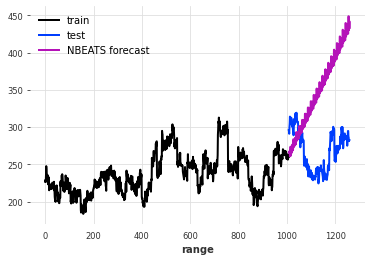

In [62]:
prediction = model.predict(prices_20.shape[0])

train_series.plot(label="train")
test_series.plot(label="test")

prediction.plot(label="NBEATS forecast")

In [63]:
from darts.models import TCNModel
from darts.utils.likelihood_models import LaplaceLikelihood

model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=LaplaceLikelihood(),
)

model.fit(train_series, epochs=400, verbose=True)
model.save_model('models/TCNModel.pth.tar')

[2022-04-02 00:56:15,702] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 973 samples.
[2022-04-02 00:56:15,702] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 973 samples.
[2022-04-02 00:56:15,712] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 3
[2022-04-02 00:56:15,712] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 3
[2022-04-02 00:56:15,728] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-04-02 00:56:15,728] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-04-02 00:56:15,730] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progr

Epoch 399: 100%|██████████| 31/31 [07:43<00:00, 14.94s/it, loss=6.34, train_loss=6.290]        


In [ ]:
pred = model.predict(n=prices_20.shape[0], num_samples=500)

# scale back:
#pred = scaler.inverse_transform(pred)

train_series.plot()
test_series.plot()
pred.plot()

In [72]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

In [76]:
train_scaler = Scaler()
train_cov_scaler = Scaler()

test_scaler = Scaler()
test_cov_scaler = Scaler()



scaled_train_series = train_scaler.fit_transform(train_series)
scaled_train_covariates = train_cov_scaler.fit_transform(train_covariates)

scaled_test_series = train_scaler.fit_transform(test_series)
scaled_test_covariates = test_cov_scaler.fit_transform(test_covariates)

In [78]:
model_cov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=300,
    random_state=0,
)

model_cov.fit(
    series=scaled_train_series.astype(float),
    past_covariates=scaled_train_covariates.astype(float),
    verbose=True,
)

model_cov.save_model('models/BlockRNNModel.pth.tar')

[2022-04-02 01:36:43,504] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 973 samples.
[2022-04-02 01:36:43,504] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 973 samples.
[2022-04-02 01:36:43,514] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-04-02 01:36:43,514] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-04-02 01:36:43,517] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-04-02 01:36:43,517] WARNING | darts.models.forecasting.torch_forecasting_model | Depreca

Epoch 299: 100%|██████████| 31/31 [06:45<00:00, 13.07s/it, loss=0.00448, train_loss=0.00372]  


In [ ]:
pred_cov = model_cov.predict(n=prices_20.shape[0])

scaled_train_series.plot("train")
scaled_test_series.plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend()
# does not work as we are using past covariates but with future covariates

# RNN

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [82]:
train_scaler = Scaler()
train_cov_scaler = Scaler()

test_scaler = Scaler()
test_cov_scaler = Scaler()



scaled_train_series = train_scaler.fit_transform(train_series)
scaled_train_covariates = train_cov_scaler.fit_transform(train_covariates)

scaled_test_series = train_scaler.fit_transform(test_series)
scaled_test_covariates = test_cov_scaler.fit_transform(test_covariates)

In [86]:
model_rnn = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="spot_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True,
)

model_rnn.fit(
    series=scaled_train_series.astype(float),
    future_covariates=scaled_train_covariates.astype(float),
    verbose=True,
)

model_rnn.save_model('models/RNNModel.pth.tar')

Epoch 299: 100%|██████████| 62/62 [16:03<00:00, 15.54s/it, loss=0.00231, v_num=logs, train_loss=0.00217]   


In [97]:
from darts.metrics import mape

def eval_model(model):
    pred_series = model.predict(n=prices_20.shape[0], future_covariates=scaled_test_covariates.astype(float))
    plt.figure(figsize=(8, 5))
    scaled_train_series.plot(label="train")
    scaled_test_series.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, scaled_test_series)))
    plt.legend()


eval_model(model_rnn)
scaled_test_covariates.plot()
scaled_test_series.plot()
# TODO since RNN looks into the past we have to give more data to the test future covarainces (so append the 13/14 rows to it then re run)
# RNN resource: https://unit8co.github.io/darts/examples/04-RNN-examples.html


ValueError: For the given forecasting case, the provided future covariates at dataset index `0` do not extend far enough into the past. The future covariates must start at time step `994`, whereas now they start at time step `1007`.

## Iteration to loading a single data source and splitting

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# training data years 2016-2019
train_prices_path = glob.glob("./prices_*.csv")
train_rain_path = glob.glob("./rain_*.csv")

# read in data
prices_train = pd.DataFrame()
rain_train = pd.DataFrame()

for f in train_prices_path:
    csv = pd.read_csv(f)
    prices_train = pd.concat([prices_train, csv])
for f in train_rain_path:
    csv = pd.read_csv(f)
    rain_train = pd.concat([rain_train, csv])